In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0
matplotlib.rc('xtick', labelsize = 20) 
matplotlib.rc('ytick', labelsize = 20)

from gsw import SA_from_SP, p_from_z, CT_from_pt, rho
from gsw import rho
import xgcm
import cartopy.feature as cft

from xhistogram.xarray import histogram

In [2]:
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33321,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:40893,Total threads: 4
Dashboard: /proxy/40197/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:35225,


In [4]:
db = '/scratch/x77/db6174/mom/archive/databases/025deg_jra55_ryf/cc_database_control.db'
session_cont = cc.database.create_session(db)

db = '/scratch/x77/db6174/mom/archive/databases/025deg_jra55_ryf/cc_database_flux_forced_vary_heat_uniform.db'
session_10W = cc.database.create_session(db)
session_20W = cc.database.create_session(db)

db = '/scratch/x77/db6174/mom/archive/databases/025deg_jra55_ryf/cc_database_flux_forced_vary_heat_uniform_5W.db'
session_5W = cc.database.create_session(db)

db = '/scratch/x77/db6174/mom/archive/databases/025deg_jra55_ryf/cc_database_flux_forced_vary_stress_20yr_avg.db'
session_wind = cc.database.create_session(db)

session_heat = [session_10W, session_5W, session_cont, session_5W, session_10W, session_20W]
session_wind = [session_wind, session_cont, session_wind]
session = [session_cont, session_10W, session_10W, session_5W, session_5W, session_20W, session_wind, session_wind]

expt = ['025deg_jra55_ryf_control', 
        '025deg_jra55_ryf_fluxH_pos10W', 
        '025deg_jra55_ryf_fluxH_neg10W',
        '025deg_jra55_ryf_fluxH_pos5W',
        '025deg_jra55_ryf_fluxH_neg5W',
        '025deg_jra55_ryf_fluxH_pos20W',
        '025deg_jra55_ryf_fluxS_050x_20yr_avg',
        '025deg_jra55_ryf_fluxS_150x_20yr_avg']

expt_heat = ['025deg_jra55_ryf_fluxH_neg10W', 
        '025deg_jra55_ryf_fluxH_neg5W',
        '025deg_jra55_ryf_control',
        '025deg_jra55_ryf_fluxH_pos5W',
        '025deg_jra55_ryf_fluxH_pos10W',
        '025deg_jra55_ryf_fluxH_pos20W']
            
expt_wind = ['025deg_jra55_ryf_fluxS_050x_20yr_avg',
             '025deg_jra55_ryf_control',
             '025deg_jra55_ryf_fluxS_150x_20yr_avg']


name_all = ['Control', '+10W/m$^2$', '-10W/m$^2$', '+5W/m$^2$', '-5W/m$^2$', '+20W/m$^2$', '0.5xW', '1.5xW']
name_heat = ['-10W/m$^2$', '-5W/m$^2$', 'Control', '+5W/m$^2$', '+10W/m$^2$', '+20W/m$^2$']
name_wind = ['0.5xW', 'Control', '1.5xW']

name_save = ['Neg10W', 'Neg5W', 'Control', 'Pos5W', 'Pos10W', 'Pos20W']

In [5]:
grav = 9.81
omega = 1/86400
r0 = 6.371 * 10**6

x_min = [-100, -250]
x_max = [ 10 , -100]
y_min = [ 20 ,  20 ]
y_max = [ 75 ,  75 ]
basin = ['NA', 'NP']

ncoarse = 12
fs = 20 ## Fontsize
rho0 = 1036

In [6]:
start_time = '2282-01-01'
end_time = '2301-12-31'

In [7]:
def var_td(variable, i):
    out = cc.querying.getvar(expt = expt[i], variable = variable, session = session[i], start_time = start_time, end_time = end_time, use_cftime = True)
    out = out.sel(time = slice(start_time, end_time)).mean('time')
    return out

def var_ti(variable, i):
    out = cc.querying.getvar(expt = expt[i], variable = variable, session = session[i], n = 1)
    return out

def var_td_heat(variable, i):
    out = cc.querying.getvar(expt = expt_heat[i], variable = variable, session = session_heat[i], start_time = start_time, end_time = end_time, use_cftime = True)
    out = out.sel(time = slice(start_time, end_time)).mean('time')
    return out

def var_ti_heat(variable, i):
    out = cc.querying.getvar(expt = expt_heat[i], variable = variable, session = session_heat[i], n = 1)
    return out

geolon_t = var_ti('geolon_t', 0)
geolat_t = var_ti('geolat_t', 0)

## South Atlantic gyre

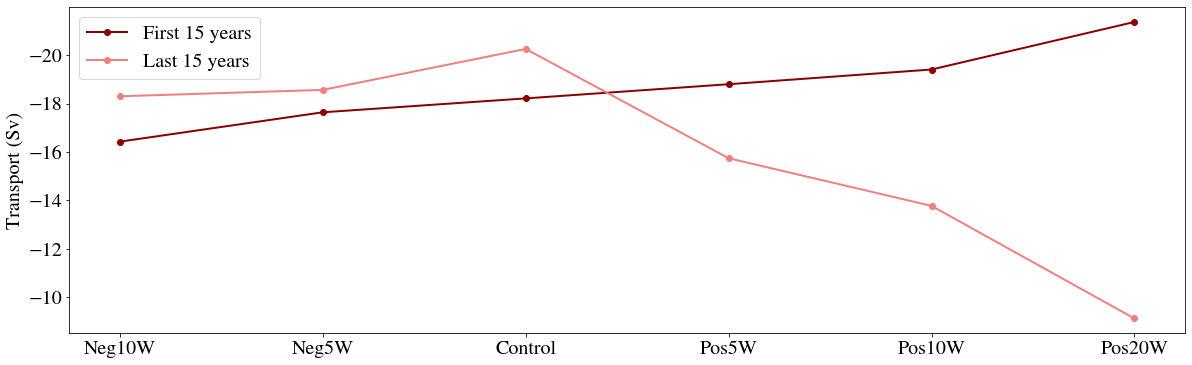

In [9]:
first15 = np.zeros(6)
last15 = np.zeros(6)

for i in np.arange(0, 6, 1):

    variable = xr.open_dataset('/g/data/x77/db6174/Flux_forced_models/025deg_flux_forced_uniform/Netcdf/Quantiles_Input/SA_STG/Density/' + name_save[i] + '.nc')
    variable = variable.to_array().mean('variable')
    
    first15[i] = variable.sel(percentile = 5, method = 'nearest').sel(time = slice(0, 15)).mean().values
    last15[i] = variable.sel(percentile = 5, method = 'nearest').sel(time = slice(85, 100)).mean().values
    
plt.figure(figsize = (20, 6))
plt.plot(np.linspace(0, 5, 6), first15, 'o-', color = 'darkred', label = 'First 15 years')
plt.plot(np.linspace(0, 5, 6), last15, 'o-', color = 'lightcoral', label = 'Last 15 years')
plt.xticks(ticks = np.linspace(0, 5, 6), labels = name_save)
plt.ylabel('Transport (Sv)', fontsize = 20)
plt.gca().invert_yaxis()
plt.legend(fontsize = 20)

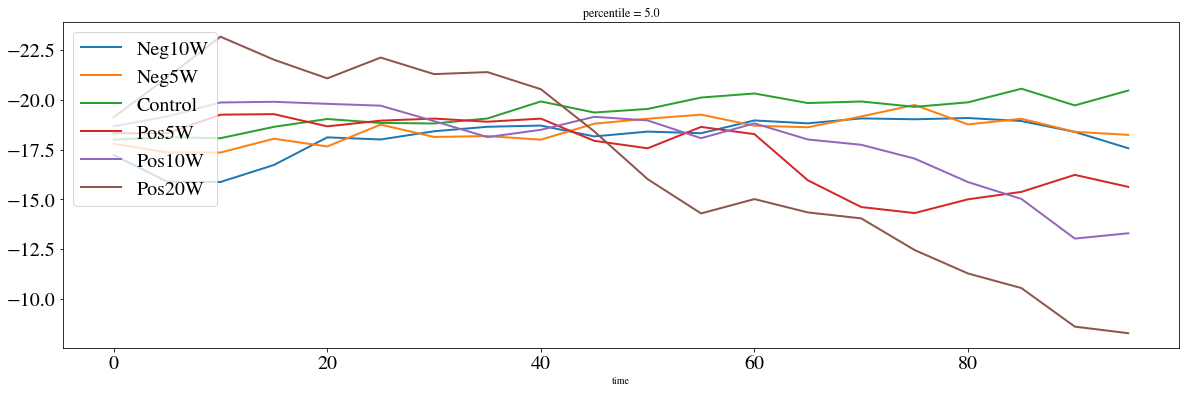

In [17]:
name_save = ['Neg10W', 'Neg5W', 'Control', 'Pos5W', 'Pos10W', 'Pos20W']
plt.figure(figsize = (20, 6))

for i in np.arange(0, 6, 1):

    variable = xr.open_dataset('/g/data/x77/db6174/Flux_forced_models/025deg_flux_forced_uniform/Netcdf/Quantiles_Input/SA_STG/Density/' + name_save[i] + '.nc')
    variable = variable.to_array().mean('variable')
    variable.sel(percentile = 5, method = 'nearest').plot(label = name_save[i])

plt.gca().invert_yaxis()
plt.legend(fontsize = 20, loc = 'upper left')

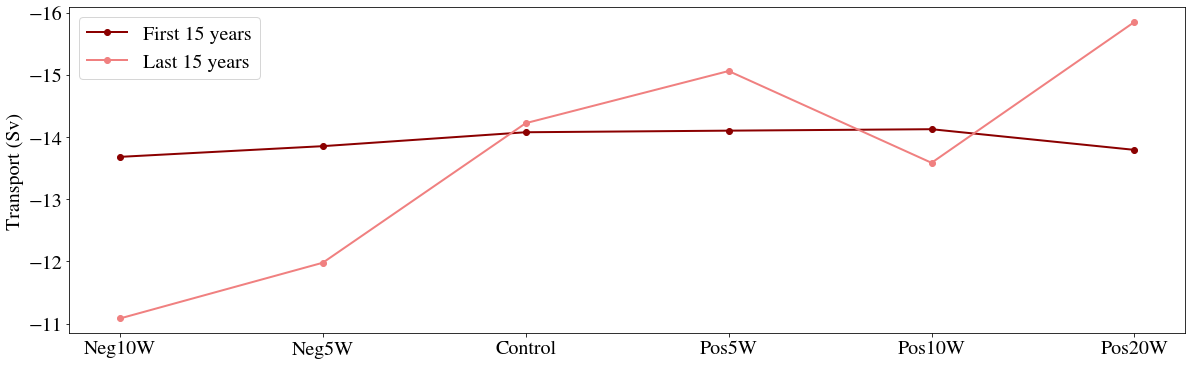

In [10]:
first15 = np.zeros(6)
last15 = np.zeros(6)

for i in np.arange(0, 6, 1):

    variable = xr.open_dataset('/g/data/x77/db6174/Flux_forced_models/025deg_flux_forced_uniform/Netcdf/Quantiles_Input/SP_STG/Density/' + name_save[i] + '.nc')
    variable = variable.to_array().mean('variable')
    
    first15[i] = variable.sel(percentile = 5, method = 'nearest').sel(time = slice(0, 15)).mean().values
    last15[i] = variable.sel(percentile = 5, method = 'nearest').sel(time = slice(85, 100)).mean().values
    
plt.figure(figsize = (20, 6))
plt.plot(np.linspace(0, 5, 6), first15, 'o-', color = 'darkred', label = 'First 15 years')
plt.plot(np.linspace(0, 5, 6), last15, 'o-', color = 'lightcoral', label = 'Last 15 years')
plt.xticks(ticks = np.linspace(0, 5, 6), labels = name_save)
plt.ylabel('Transport (Sv)', fontsize = 20)
plt.gca().invert_yaxis()
plt.legend(fontsize = 20)

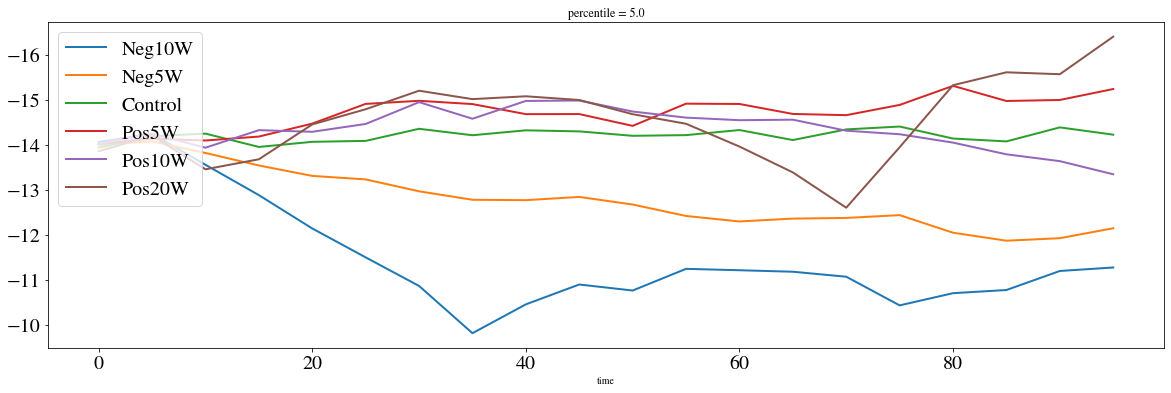

In [21]:
name_save = ['Neg10W', 'Neg5W', 'Control', 'Pos5W', 'Pos10W', 'Pos20W']
plt.figure(figsize = (20, 6))

for i in np.arange(0, 6, 1):

    variable = xr.open_dataset('/g/data/x77/db6174/Flux_forced_models/025deg_flux_forced_uniform/Netcdf/Quantiles_Input/SP_STG/Density/' + name_save[i] + '.nc')
    variable = variable.to_array().mean('variable')
    variable.sel(percentile = 5, method = 'nearest').plot(label = name_save[i])

plt.gca().invert_yaxis()
plt.legend(fontsize = 20, loc = 'upper left')